DIY Spectrometer calibration
============================

Spectrometers are used to measure light. A probe is pointed at the light source and feeds the light sample through to the optical bench. The light hits a prism, or diffraction grating, and the spectrum of light is spread out accross a sensor that reports a measure related to the ammount of light that hits the sensor. 

Depending on your spectrometer, you may be need to calibrate it. Here's what we did step by step with our OceanOptics JAZ spectrometer to get units in W/cm2/nm. 

# OceanOptics JAZ

<img src="../../img/jaz.png" alt="OceanOptics JAZ spectrometer" style="width:300px">

Our JAZ spectrometer

## Obtaining measurements

OceanView software, matlab, etc. Easiest in Python. 

### `Seabreeze`




In [ ]:
from seabreeze import spectrometers

def ocean_optics_measurement(output='./my_measurement.csv'):
    try:
        oo = spectrometers.Spectrometer.from_serial_number('JAZA1505')
        oo.integration_time_micros(1000*1000)  # 1 s
        wls = oo.wavelengths()
        counts = oo.intensities()
        
    except KeyboardInterrupt:
        print('> Measurement terminated  by user')

    finally:
        oo.close()
        
if __name__ == '__main__':
    ocean_optics_measurement()

### `pyplr.oceanops.OceanOptics`

Interface with more features

In [3]:
from pyplr import oceanops

def ocean_optics_measurement('./my_measurement.csv'):
    try:
        oo = oceanops.OceanOptics.from_serial_number('JAZA1505')
        wls = oo.wavelengths()
        counts, info = oo.measurement(nscans_to_average=3)
        
    except KeyboardInterrupt:
        print('> Measurement terminated  by user')
    
    finally:
        oo.close()

if __name__ == '__main__':
    ocean_optics_measurement()

True


## Wavelength calibration


Our JAZ spectrometer has internal wavelengths that are calibrated in house. Overtime the reported wavelengths are liable to shift due to mechanical shock and other factors. If you have access to a light source capable of producing spectral lines you can perform your own wavelength calibration. 

Spectral lines are fascinating properties of the universe. 

We borrowed an argon lamp from our local physics department.

<img width=400 src='../../img/jaz_argon_lamp.png'>


Measurement of the lamp produced a spectrum with lots of spectral lines. The next thing we needed to do was find out the known positions of these spectral lines. These can be obtained from the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/lines_form.html)

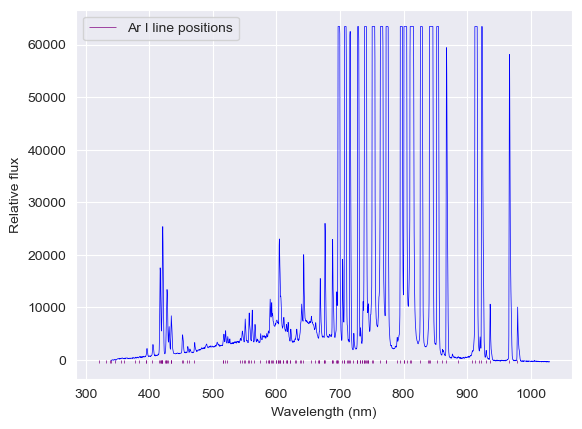

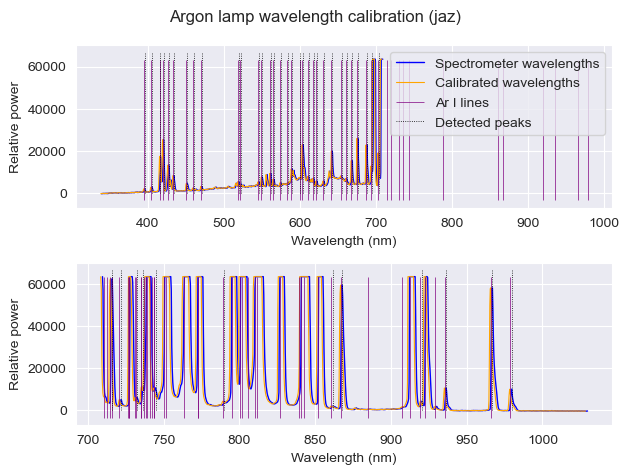

In [13]:
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns

sns.set_style('darkgrid')

# Details of measurement
device = 'jaz'
light_source = 'Ar'

# Load spectrum
spd = pd.read_csv(f'../../../BakerWadeBBSRC/data/spectral/{device}_{light_source}_spd.csv', index_col=None)
lines = pd.read_csv('../../../BakerWadeBBSRC/data/spectral/lines/Ar_1_lines_300_1000.csv')
#lines = lines[lines.rel_pwr > 4]  # drop tiny peaks

#%% Choose some peaks based on some criteria. Play with these parameters to 
# find so that there are several detected peaks across the range of wavelengths
peak_idxs = find_peaks(spd['pwr'], height=1800, prominence=300, threshold=30, distance=10)[0]
peaks = spd.loc[peak_idxs].reset_index()

# # Find 'true' wls, assuming they are the closest to the left. Probably not 
# the best approach, because some lines are not resolved by the spectrometer.
# true_wl = []
# for _, row in peaks.iterrows():
#     diff = (lines.wl-row.wl)
#     true = diff[diff < 0].abs().argmin()
#     true_wl.append(lines.loc[true, 'wl'])

# For better results, manually choose true wavelengths by inspecting the line
# positions and general pattern of drift
true_wl = [394.8979, 404.4418, 415.859, 419.8317, 426.6286, 433.3561, 
            451.0733, 459.6097, 470.2316, 518.7746, 522.1271, 545.1652,
            549.5874, 560.6733, 565.0704, 573.952, 583.4263, 588.8584,
            599.8999, 603.2127, 610.5635, 617.3096, 621.5938, 630.7657,
            641.6307, 653.8112, 660.4853, 667.7282, 675.2834, 687.1289,
            693.7664, 703.0251, 714.7042, 720.698, 731.1716, 735.3293,
            743.6297, 789.1075, 860.5776, 866.7944, 919.4638, 935.422, 
            965.7786, 978.4503]


# Eyeball the graph and remove peaks that should not be used, for example,
# the peaks without proximal "true" lines
drop_px = [448, 648, 947]
peaks = peaks.loc[~peaks.pxl.isin(drop_px)]  # non existant peak
peaks['true_wl'] = true_wl

# # Plot the spd and peaks
plt.plot(spd['wl'], spd['pwr'], c='blue', lw=.5)
#plt.scatter(peaks['wl'], peaks['pwr'], marker='x', c='k')
ymin, ymax = plt.gca().get_ylim()
plt.vlines(lines['wl'], -500, 0, color='purple', lw=.5, label='Ar I line positions')
#plt.vlines(peaks['wl'], ymin, ymax, color='k', ls=':', lw=.5, label='Detected peaks')

plt.legend()


plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative flux')
#plt.savefig('../img/{device}_{light_source}_lines_plot.pdf')

#%%
# Polynomial fit
poly = np.polyfit(peaks['pxl'], peaks['true_wl'], deg=3)
calibrated_wls = np.polyval(poly, spd.pxl)
spd['cal_wl'] = calibrated_wls
#spd.to_csv(f'../hardware/OceanOptics/{device}/{device}_Ar_1_calibrated_wavelengths.csv', index=None)

# Plot
fig, axs = plt.subplots(2)

peaks1 = peaks.loc[peaks.pxl<1024]
spd1 = spd.loc[spd.pxl<1024]
lines1 = lines.loc[lines['wl'] < spd1['wl'].max()]

axs[0].plot(spd1.wl, spd1.pwr, c='blue', lw=1, label='Spectrometer wavelengths')
axs[0].plot(spd1.cal_wl, spd1.pwr, c='orange', lw=.8, label='Calibrated wavelengths')
ymin, ymax = axs[0].get_ylim()
axs[0].vlines(true_wl, ymin, ymax*.95, color='purple', lw=.5, label='Ar I lines')
axs[0].vlines(peaks1['wl'], 0, ymax, ls=':', color='k', lw=.6, label='Detected peaks')
axs[0].legend()

peaks2 = peaks.loc[peaks.pxl>=1024]
spd2 = spd.loc[spd.pxl>=1024]
lines2 = lines.loc[lines['wl'] > spd2['wl'].min()]

axs[1].plot(spd2.wl, spd2.pwr, c='blue', lw=1, label='Spectrometer wavelengths')
axs[1].plot(spd2.cal_wl, spd2.pwr, c='orange', lw=.8, label='Calibrated wavelengths')
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(lines2['wl'], ymin, ymax*.95, color='purple', lw=.5, label='Ar I line positions')
axs[1].vlines(peaks2['wl'], 0, ymax, ls=':', color='k', lw=.6, label='Detected peaks')

for ax in axs:
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Relative power')
plt.suptitle(f'Argon lamp wavelength calibration ({device})')
plt.tight_layout()    
#fig.savefig(f'../figs/{device}_{light_source}_wl_calib_plot.pdf')


In [20]:
spd2.wl

1024     709.616625
1025     709.956017
1026     710.295361
1027     710.634658
1028     710.973908
           ...     
2043    1028.620790
2044    1028.905195
2045    1029.189540
2046    1029.473824
2047    1029.758047
Name: wl, Length: 1024, dtype: float64

## Irradiance calibration

<img width=400 src='../../img/jaz_hl_2000_cal.png'>